# Web banners

## Introduction
This Python notebook explores an online display advertisement data set. The data are collected by a [retargeting company](https://en.wikipedia.org/wiki/Behavioral_retargeting) to analyze the declining gross profit on one of its client advertiser accounts.  

This exercise includes exploratory data analysis and predictive analytics.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
import seaborn as sns
import squarify

In [2]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["#3498db", "white", "#e0749d"])
cpal = [
    "#3498db", "#e0749d", "#33d3af", "#ffd92f", "#8da0cb", "#fc8d62",
    "#e5c494", "#bababa"
]

sns.set_style("whitegrid")
sns.set_palette(cpal)
%matplotlib inline

## I. Exploring the data set

### Loading the data

In [3]:
data_path = "/.../data.csv"

In [4]:
df = pd.read_excel(io=data_path)

### Reviewing the features

The raw data set is composed of 1 time, 1 ordinal, 3 categorical, and 6 numerical features.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15403 entries, 0 to 15402
Data columns (total 11 columns):
day                        15403 non-null datetime64[ns]
user_segment               15403 non-null object
user_engagement            15403 non-null object
banner                     15403 non-null object
placement                  14990 non-null object
displays                   15403 non-null int64
cost                       15403 non-null float64
clicks                     15403 non-null int64
revenue                    15403 non-null float64
post_click_conversions     15403 non-null int64
post_click_sales_amount    15403 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 1.3+ MB


In [6]:
df.sample(5, random_state=0)

,day,user_segment,user_engagement,banner,placement,displays,cost,clicks,revenue,post_click_conversions,post_click_sales_amount
12608,2016-06-11,Cluster 1,Medium,728 x 90,B,3948,0.9301,20,2.1875,4,249.2138
2085,2016-04-10,Cluster 3,Medium,728 x 90,NaN,13,0.0104,0,0.0000,0,0.0000
1919,2016-04-10,Cluster 1,Medium,468 x 60,B,55,0.0145,0,0.0000,0,0.0000
9757,2016-05-23,Cluster 3,Medium,728 x 90,C,1459,1.1160,27,1.4413,0,0.0000
5842,2016-04-28,Cluster 3,High,728 x 90,C,925,0.9757,11,0.5963,0,0.0000


### Data cleaning

#### Applying naming convention
- Features which start with ***adv*** are relative to the advertiser.  
- Features which start with ***ret*** are relative to the retargeting company.  
- ***ret_revenue*** could have been named ***adv_cost*** (but arbitrarily isn't).  
- Because we only have data from the retargeter, ***ret_profit*** and ***adv_profit*** are respectively ***ret_revenue - ret_cost*** and ***post_click_sales_amount - ret_revenue***. These costs constiute most of the COGS for the retargeter but only a small fraction of the COGS for the advertiser. Hence ***ret_profit*** and ***adv_profit*** are slightly misleading names.
- Features which names don't start with ***adv*** nor ***ret*** indicate obvious or irrelevant relationships to the advertiser/retargeting company.

####  Converting ordinal features to numerals
- I convert user engagement levels from strings (*"Low"*, *"Medium"*, *"High"*) to a zero-to-one scale (with one being the highest level of engagement).

#### Extracting a categorical feature from dates
- Because there seems to be a day-of-the-week effect (more visible on the *Daily revenues* chart below), I create the ***day_of_the_week*** feature so it can be analyzed more separately afterwards.

In [7]:
df.rename(columns={"cost": "ret_cost", "revenue": "ret_revenue"}, inplace=True)

df["ret_profit"] = df.ret_revenue - df.ret_cost
df["adv_profit"] = df.post_click_sales_amount - df.ret_revenue

engagement_rating = {"Low": 0, "Medium": .5, "High": 1}
df.replace({"user_engagement": engagement_rating}, inplace=True)

df["day_of_week"] = pd.to_datetime(df["day"])
df["day_of_week"] = df["day_of_week"].dt.weekday_name

#### Analyzing missing data

Some values are missing for regarding the ad placement feature. This affects about 2.7% of our data set but mostly concerns ads that generate below average revenues, clicks and sales. I decide to exclude observations with missing data.

In [8]:
print("Share of observations with missing placement value: ",
      df.placement.isnull().sum() / len(df.index) * 100, "%")

Share of observations with missing placement value:  2.68129585146 %


In [9]:
df.isnull().sum()

day                          0
user_segment                 0
user_engagement              0
banner                       0
placement                  413
displays                     0
ret_cost                     0
clicks                       0
ret_revenue                  0
post_click_conversions       0
post_click_sales_amount      0
ret_profit                   0
adv_profit                   0
day_of_week                  0
dtype: int64

In [10]:
df[df.placement.isnull()].describe()

,user_engagement,displays,ret_cost,clicks,ret_revenue,post_click_conversions,post_click_sales_amount,ret_profit,adv_profit
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,0.619855,7.673123,0.006734,0.012107,0.000715,0.004843,0.458009,-0.006019,0.457294
std,0.371357,10.353330,0.009922,0.109494,0.007111,0.069504,6.832540,0.012288,6.832592
min,0.000000,1.000000,0.000600,0.000000,0.000000,0.000000,0.000000,-0.095600,-0.111400
25%,0.500000,2.000000,0.001600,0.000000,0.000000,0.000000,0.000000,-0.008000,0.000000
50%,0.500000,4.000000,0.003200,0.000000,0.000000,0.000000,0.000000,-0.003200,0.000000
75%,1.000000,10.000000,0.008000,0.000000,0.000000,0.000000,0.000000,-0.001300,0.000000
max,1.000000,81.000000,0.095600,1.000000,0.111400,1.000000,121.318000,0.109800,121.318000


In [11]:
df[~df.placement.isnull()].describe()

,user_engagement,displays,ret_cost,clicks,ret_revenue,post_click_conversions,post_click_sales_amount,ret_profit,adv_profit
count,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000
mean,0.491628,15944.702602,11.687087,166.298866,18.429775,43.479653,2182.469718,6.742687,2164.039944
std,0.401370,44930.580339,45.957521,737.853838,98.075096,216.526406,10662.696265,69.838680,10575.798226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-184.128400,-26.003600
25%,0.000000,102.000000,0.030300,0.000000,0.000000,0.000000,0.000000,-0.054650,-0.184850
50%,0.500000,1337.500000,0.377950,7.000000,0.542300,0.000000,0.000000,-0.000600,0.000000
75%,1.000000,9624.000000,2.707500,57.000000,4.000000,3.000000,185.513775,1.003100,180.567950
max,1.000000,455986.000000,556.704800,14566.000000,2096.211600,3369.000000,199930.318000,1695.886300,198037.318000


## II. Identifying the issue

Revenues are plummeting for both the advertiser and the retargeter. They both are very correlated (coefficient of about 0.9). I can focus on one of the two variables from now on (that is ***ret_revenue***) knowing that the other behaves roughly in the same way.

In [12]:
df_by_day = df.groupby("day")

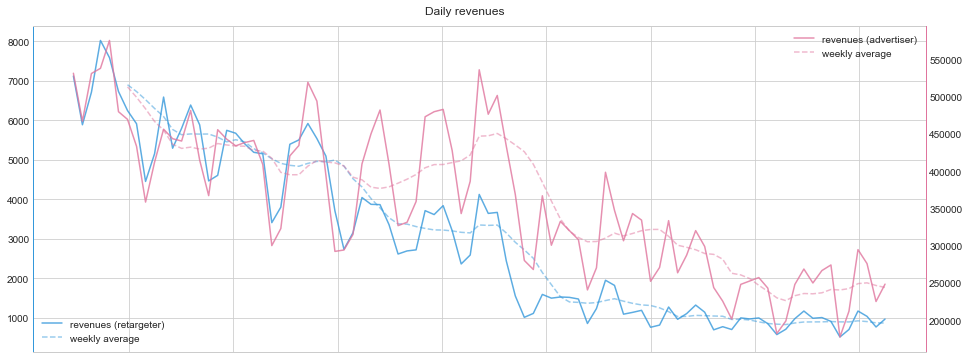

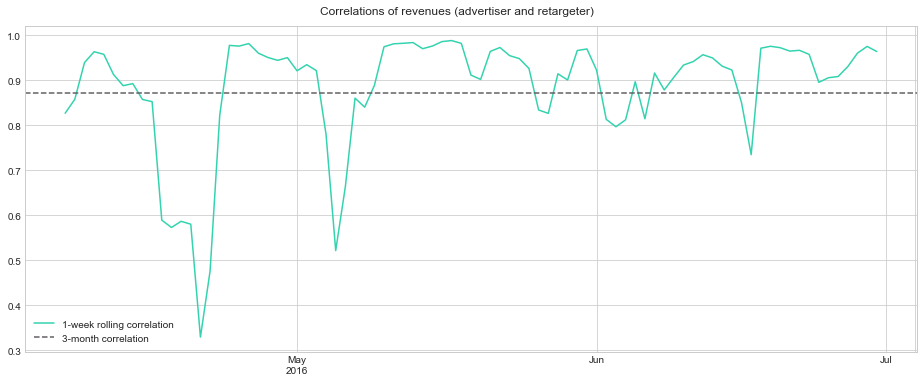

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(
    df_by_day.ret_revenue.sum(),
    color=cpal[0],
    alpha=.8,
    label="revenues (retargeter)")
ax.spines["left"].set_color(cpal[0])
ax.legend(loc=2)
ax.set_xticklabels([])

ax2 = ax.twinx()
ax2.plot(
    df_by_day.post_click_sales_amount.sum(),
    color=cpal[1],
    alpha=.8,
    label="revenues (advertiser)")
ax2.legend(loc=0)

ax.plot(
    df_by_day.ret_revenue.sum().rolling(window=7).mean(),
    color=cpal[0],
    label="weekly average",
    linestyle="--",
    alpha=.5)
ax.legend(loc=3)

ax2.plot(
    df_by_day.post_click_sales_amount.sum().rolling(window=7).mean(),
    color=cpal[1],
    label="weekly average",
    linestyle="--",
    alpha=.5)
ax2.legend(loc=0)

sns.despine(ax=ax, right=True, left=False, top=False)
sns.despine(ax=ax2, left=True, right=False)
ax2.spines["right"].set_color(cpal[1])
ax2.grid(False)
fig.suptitle(t="Daily revenues", y=.925)

fig, ax = plt.subplots(figsize=(16, 6))

df_by_day.post_click_sales_amount.sum().rolling(window=7).corr(
    df_by_day.ret_revenue.sum()).plot(
        color=cpal[2], label="1-week rolling correlation")
plt.axhline(
    y=np.corrcoef((df_by_day.ret_revenue.sum()),
                  (df_by_day.post_click_sales_amount.sum()))[0, 1],
    color="#635f62",
    linestyle="--",
    label="3-month correlation")
fig.suptitle(t="Correlations of revenues (advertiser and retargeter)", y=.925)
ax.xaxis.label.set_visible(False)
ax.legend(loc=0);

### Analyzing the funnel

We go through each step of the funnel, from the daily costs to display ads to the post-click sales amount. All metrics are in the red (evolving in the wrong direction) except the average user engagement level, which increases (this actually raises the question of the quality of the user engagement measurement) and the conversion per click rate. However, the latter does not rise fast enough to compensate the collapse in number of clicks.  

Another interesting point is that the CPM almost doubled during the first 1.5 month of the exercise, then suddenly dropped below its initial level in order to rise again (top-right corner).  

*(To be read like a Western comic book, from left to right.)*

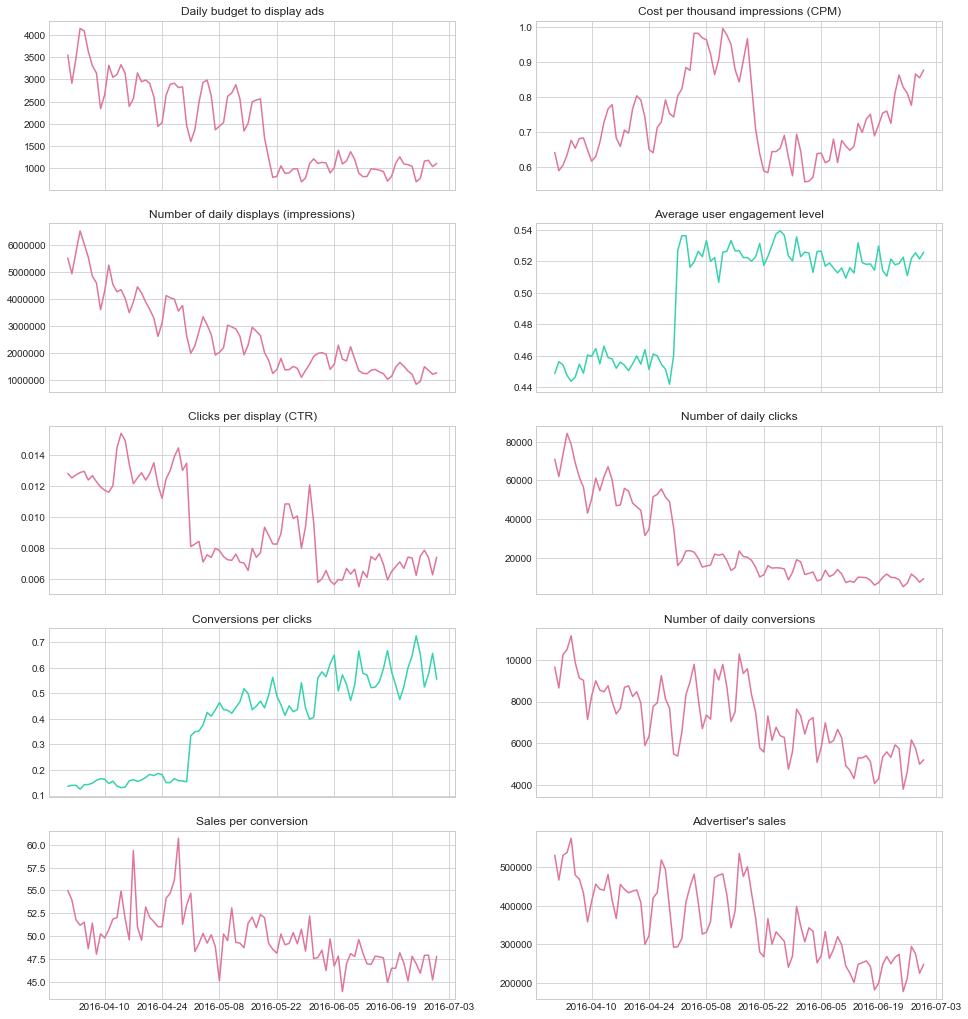

In [14]:
fig = plt.figure(figsize=(16, 18))

ax = fig.add_subplot(5, 2, 1)
ax.set_title("Daily budget to display ads")
ax.plot(df_by_day.ret_cost.sum(), color=cpal[1])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 2)
ax.set_title("Cost per thousand impressions (CPM)")
ax.plot(1000  * df_by_day.ret_cost.sum() / df_by_day.displays.sum(), color=cpal[1])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 3)
ax.set_title("Number of daily displays (impressions)")
ax.plot(df_by_day.displays.sum(), color=cpal[1])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 4)
ax.set_title("Average user engagement level")
ax.plot(df_by_day.user_engagement.mean(), color=cpal[2])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 5)
ax.set_title("Clicks per display (CTR)")
ax.plot(df_by_day.clicks.sum() / df_by_day.displays.sum(), color=cpal[1])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 6)
ax.set_title("Number of daily clicks")
ax.plot(df_by_day.clicks.sum(), color=cpal[1])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 7)
ax.set_title("Conversions per clicks")
ax.plot(
    df_by_day.post_click_conversions.sum() / df_by_day.clicks.sum(),
    color=cpal[2])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 8)
ax.set_title("Number of daily conversions")
ax.plot(df_by_day.post_click_conversions.sum(), color=cpal[1])
ax.set_xticklabels([])

ax = fig.add_subplot(5, 2, 9)
ax.set_title("Sales per conversion")
ax.plot(
    df_by_day.post_click_sales_amount.sum() /
    df_by_day.post_click_conversions.sum(),
    color=cpal[1])

ax = fig.add_subplot(5, 2, 10)
ax.set_title("Advertiser's sales")
ax.plot(
    df_by_day.post_click_sales_amount.sum(), color=cpal[1]);

### Categorical data analysis

From the funnel charts, it seems that ads need to be displayed more often (through increased budgets and/or getting more of these low-CPM impressions). This is to fix the advertisement *quantity* issue.  

But there is also a *quality* problem, as seen in the drop in click-through-rate mainly (but not only). To better understand what went wrong on that level, I analyze user clusters (as defined by the advertiser), banner sizes, and banner placements.

Bonus: Are the spikes following a pattern? When I first plotted the revenues and other metrics, I thought that there might be a day-of-the-week. This is also something I investigate.

In [15]:
df_by_cluster = df.groupby(["day", "user_segment"]).sum().reset_index()
df_by_cluster.user_engagement = df.groupby(
    ["day", "user_segment"]).mean().reset_index().user_engagement
df_by_size = df.groupby(["day", "banner"]).sum().reset_index()
df_by_placement = df.groupby(["day", "placement"]).sum().reset_index().groupby("placement")

####  User segments

The clustering exercise is performed by the advertiser and the segmentation is given. Most of the spendings are geared towards the Cluster 1 (one order of magnitude above the second biggest cluster for the period). Cluster 2 is dropped at the end of the first month for unspecified reasons. I suspect the cluster's low engagement level to be the cause, but it's actually a pity given that it was the most profitable one out of the three segments.

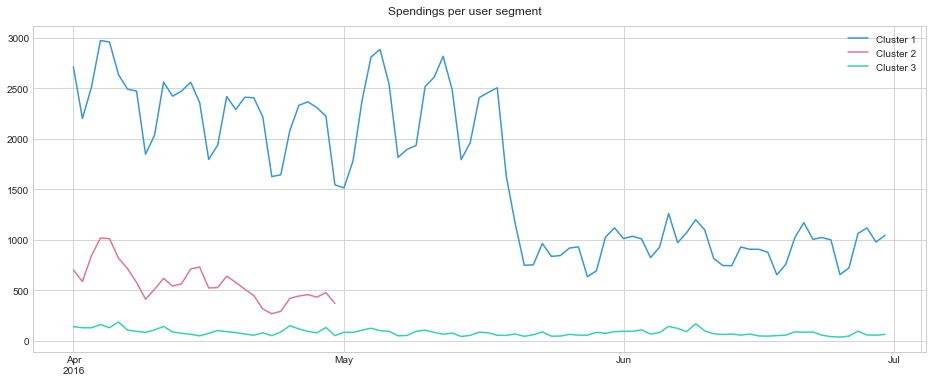

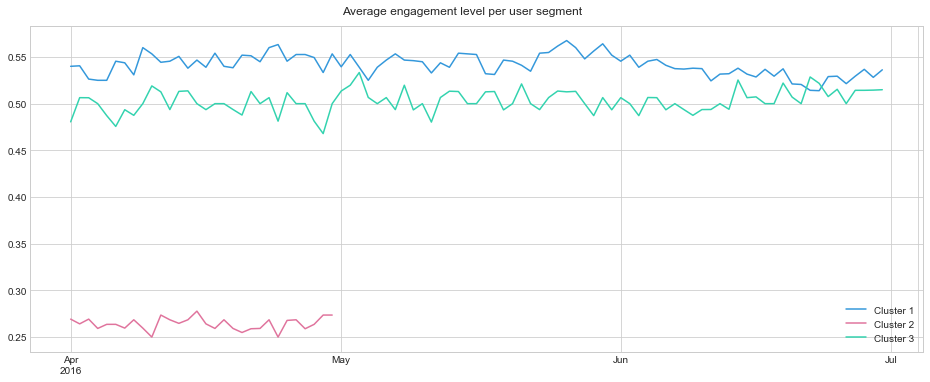

In [16]:
labels = []
for feature in ["ret_cost", "user_engagement"]:
    fig, ax = plt.subplots(figsize=(16, 6))
    for key, grp in df_by_cluster.groupby("user_segment"):
        ax = grp.plot(ax=ax, x="day", y=feature, color=cpal[int(key[-1:]) - 1])
        labels.append(key)
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc="best")
    ax.xaxis.label.set_visible(False)
    fig.suptitle(t="Spendings per user segment", y=.925)
fig.suptitle(
    t="Average engagement level per user segment", y=.925);

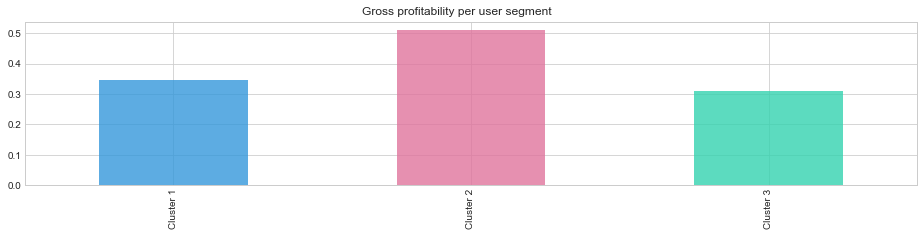

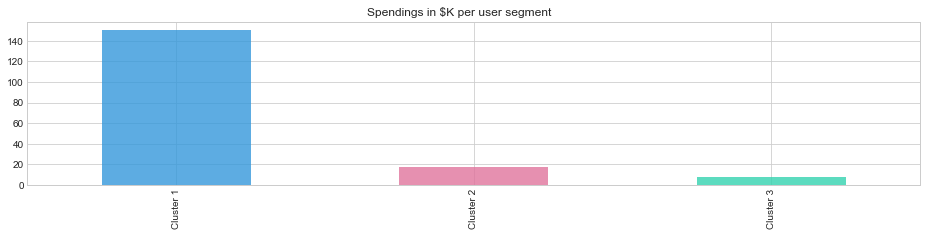

In [17]:
fig, ax = plt.subplots(figsize=(16, 3))
((df_by_cluster.groupby(["user_segment"]).ret_revenue.sum() -
  df_by_cluster.groupby(["user_segment"]).ret_cost.sum()) /
 df_by_cluster.groupby(["user_segment"]).ret_revenue.sum()).plot(
     kind="bar", color=cpal, alpha=.8)
ax.xaxis.label.set_visible(False)
fig.suptitle(t="Gross profitability per user segment", y=.95)

fig, ax = plt.subplots(figsize=(16, 3))
(df_by_cluster.groupby(["user_segment"]).ret_cost.sum() / 1000).plot(
    kind="bar", color=cpal, alpha=.8)
ax.xaxis.label.set_visible(False)
fig.suptitle(t="Spendings in $K per user segment", y=.95);

#### Placement
Ad locations are related to banner sizes and the heatmap below shows that some pairs are more in a more exclusive relationship than others (580x400 banners seems to be displayed mostly at placement E for instance).  

Placement E is the most sought after by the retargeter despite yielding the lowest gross profitability. It often hosts banner of size 580x400 and 800x250, which are not great revenue generators (as seen in the following subsection ***Size***).  
Placements C and D are the most profitable. C is less restrictive regarding banner sizes, which might explain why it is used more often than the barely used placement D.  

In [18]:
reg_df = df[~df.placement.isnull()].reset_index(drop=True)

for i in reg_df.placement.unique():
    reg_df.loc[:, "pla_%s" % i] = np.where(reg_df["placement"] == i, 1, 0)
for i in reg_df.banner.unique():
    reg_df.loc[:, "banner_%s" % i.replace(" ", "")] = np.where(
        reg_df["banner"] == i, 1, 0)

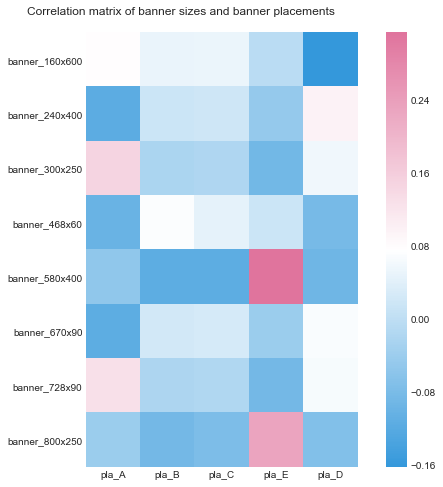

In [19]:
corr_features = reg_df[reg_df.columns[14:27]].corr()
corr_features.drop(corr_features.columns[5:], axis=1, inplace=True)
corr_features.drop(corr_features.index[:5], inplace=True)

f, ax = plt.subplots(figsize=(10, 8))
f.suptitle(t="Correlation matrix of banner sizes and banner placements", y=.925)
sns.heatmap(
    corr_features,
    square=True,
    ax=ax,
    cmap=cmap);

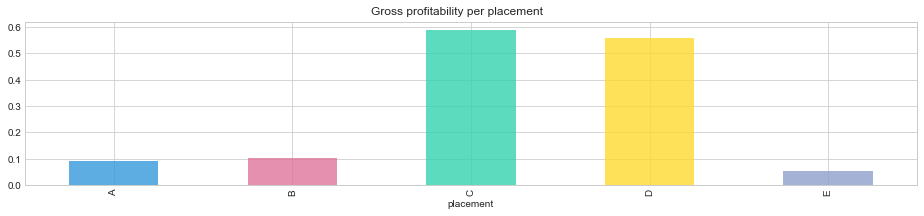

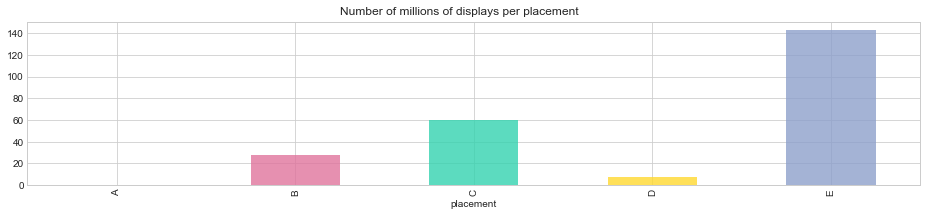

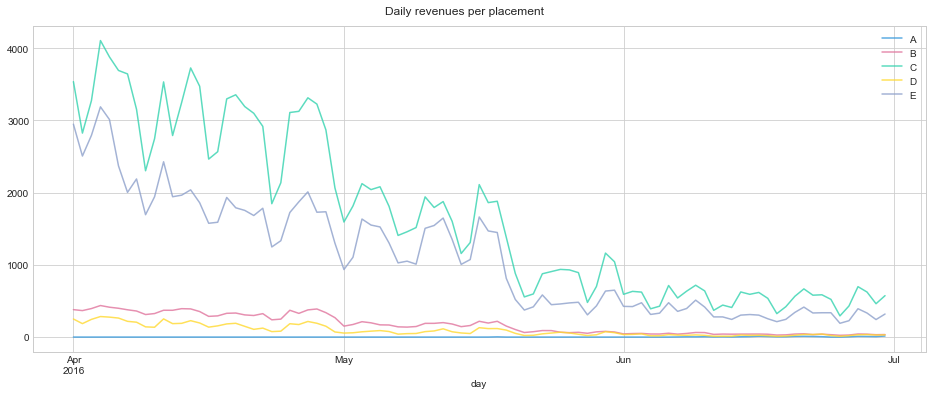

In [20]:
fig, ax = plt.subplots(figsize=(16, 3))
((df_by_placement.ret_revenue.sum() - df_by_placement.ret_cost.sum()) /
 df_by_placement.ret_revenue.sum()).plot(
     kind="bar", color=cpal, alpha=.8)
fig.suptitle(t="Gross profitability per placement", y=.95)

fig, ax = plt.subplots(figsize=(16, 3))
(df_by_placement.displays.sum() / 1000000).plot(
    kind="bar", color=cpal, alpha=.8)
fig.suptitle(t="Number of millions of displays per placement", y=.95)

fig, ax = plt.subplots(figsize=(16, 6))
labels = []
for key, grp in df_by_placement:
    ax = grp.plot(ax=ax, kind="line", x="day", y="ret_revenue", alpha=.8)
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="best")
fig.suptitle(t="Daily revenues per placement", y=.925);

#### Size
Four banner sizes make up for more than 90% of the banners deployed (out of eight sizes available). 240x400 banners have the highest gross profitability but budgets allocated to it, like all other banner types, have been decreased. Two banner types (468x60 and 800x250) are highly unprofitable but they still constitute the minority of the banner types.

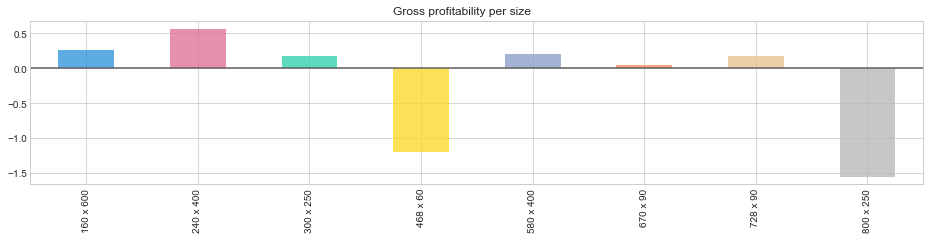

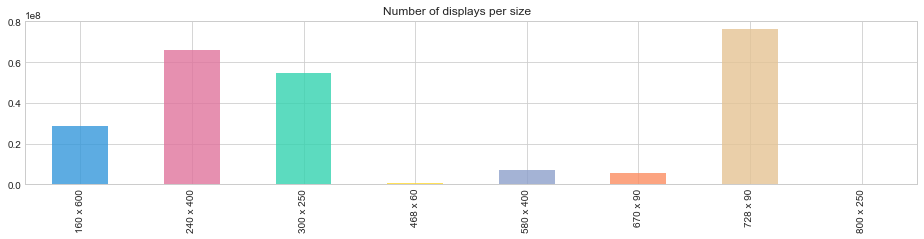

In [21]:
fig, ax = plt.subplots(figsize=(16, 3))
((df_by_size.groupby("banner").ret_revenue.sum() - df_by_size.groupby("banner")
  .ret_cost.sum()) / df_by_size.groupby("banner").ret_revenue.sum()).plot(
      kind="bar", color=cpal, alpha=.8)
plt.axhline(y=0, color="#635f62")
ax.xaxis.label.set_visible(False)
fig.suptitle(t="Gross profitability per size", y=.95)

fig, ax = plt.subplots(figsize=(16, 3))
df_by_size.groupby("banner").displays.sum().plot(
      kind="bar", color=cpal, alpha=.8)
ax.xaxis.label.set_visible(False)
fig.suptitle(t="Number of displays per size", y=.95);

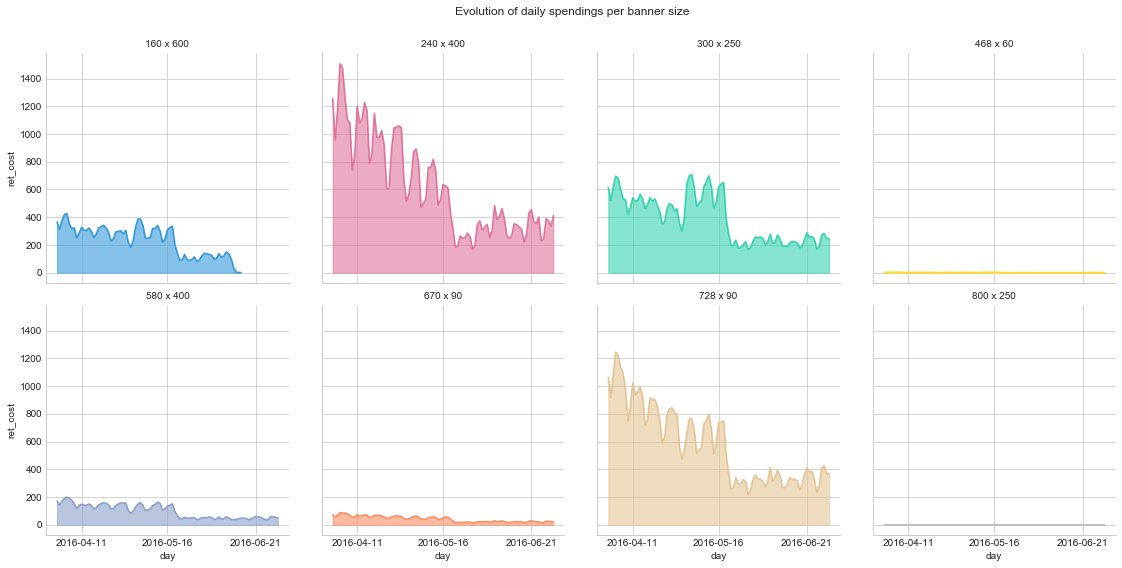

In [22]:
g = sns.FacetGrid(
    df_by_size.groupby(["banner", "day"]).sum().reset_index(),
    col="banner",
    hue="banner",
    col_wrap=4,
    size=4)
g = g.map(plt.plot, "day", "ret_cost")
g = g.map(
    plt.fill_between, "day", "ret_cost", alpha=0.6).set_titles("{col_name}")
plt.subplots_adjust(top=0.9, )
g.set(xticks=[
    df_by_size.day.unique()[10],
    df_by_size.day.unique()[len(df_by_size.day.unique()) // 2],
    df_by_size.day.unique()[-10]
])
g.fig.suptitle("Evolution of daily spendings per banner size");

#### Day of the week
Average profitability flucuates between 34.5% and 39.5% depending on the day. It might be a big deal in other contexts but probably no low-hanging fruits here (other banner features seemed to have more variable impacts on the revenues and profitability). The next part, ***III. Supervised learning***, confirms this assumption. Controlling for other factors, it seems that the day-of the-week effect is slim.

In [23]:
order = [
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday",
    "Sunday"
]
df_by_weekday = df.groupby("day_of_week").sum().reindex(index=order)

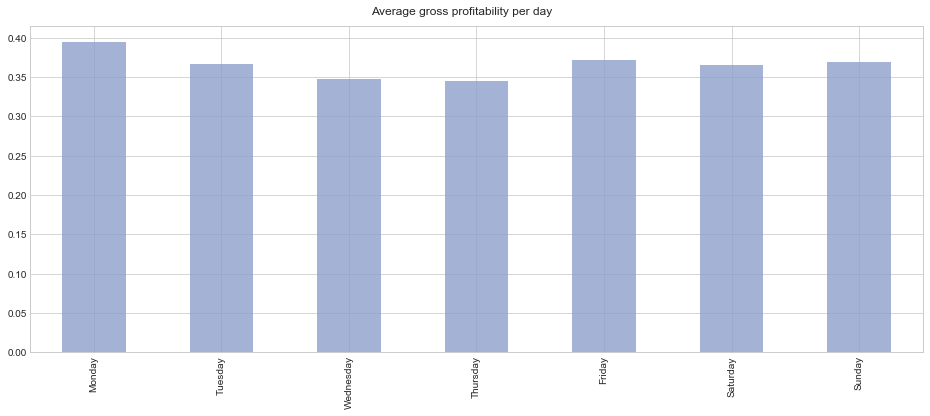

In [24]:
fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle(t="Average gross profitability per day", y=.925)
((df_by_weekday.ret_revenue - df_by_weekday.ret_cost) /
 df_by_weekday.ret_revenue).plot(
     kind="bar", color=cpal[4], alpha=.8)
ax.xaxis.label.set_visible(False);

## III. Supervised learning

In this section I deploy a few models readily available in scikit-learn.  

The goal is generate insight regarding the categorical features (confirm or contradict the observations made in the previous section) and determine if the retargeter could have done better / can do better from now on. For the latter, I try to predict the June revenues with models trained on the May data.

In [25]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor

from sklearn import metrics

### Selecting features

Most of the features that the retargeter can control are categorical (targeted user segment, banner size and location, day of the week), so I apply a one-hot encoder. Other features such as user engagement levels and number of clicks are not real features but, rather, could have been alternative targets.

We try to predict the revenues based on all categorical data and spending figures. From the correlation matrix heatmap we can tell that weekdays should have a low impact.

In [26]:
reg_df = df[~df.placement.isnull()].reset_index(drop=True)

for i in reg_df.placement.unique():
    reg_df.loc[:, "pla_%s" % i] = np.where(reg_df["placement"] == i, 1, 0)
for i in reg_df.banner.unique():
    reg_df.loc[:, "banner_%s" % i.replace(" ", "")] = np.where(
        reg_df["banner"] == i, 1, 0)
for i in reg_df.user_segment.unique():
    reg_df.loc[:, "cluster_%s" % i[-1:]] = np.where(
        reg_df["user_segment"] == i, 1, 0)
for i in order:
    reg_df.loc[:, "w_%s" % i] = np.where(reg_df["day_of_week"] == i, 1, 0)

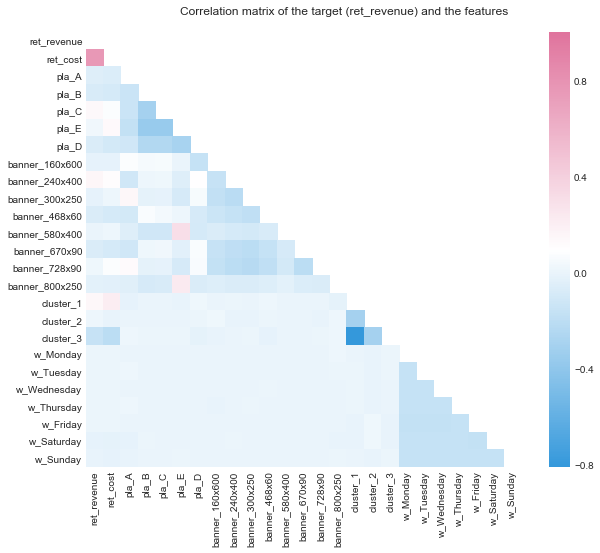

In [27]:
corr_features = reg_df[reg_df.columns[np.r_[8, 6, 14:37]]].corr()

mask = np.zeros_like(corr_features)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle(
    t="Correlation matrix of the target (ret_revenue) and the features",
    y=.925)
sns.heatmap(
    corr_features, mask=mask, square=True, ax=ax, cmap=cmap);

In [28]:
X = reg_df[reg_df.columns[np.r_[6, 14:37]]][reg_df.day.dt.month == 5]
y = reg_df[reg_df.day.dt.month == 5].ret_revenue

### Ordinary least square regression
The OLS regression has a good grasp of the impact of the categorical data, which concurs with the feature analysis. However, inputing many variables seems to diminish the impact of budget levels (***ret_cost***) despite it being the variable the most correlated to revenues.

In [29]:
reg0 = linear_model.LinearRegression()
reg0 = reg0.fit(X, y)

reg_df["pred_y_ols"] = reg0.predict(reg_df[reg_df.columns[np.r_[6, 14:37]]])

print("mean squared error: ",
      metrics.mean_squared_error(reg_df[reg_df.day.dt.month == 6].ret_revenue,
                                  reg_df[reg_df.day.dt.month == 6].pred_y_ols))

mean squared error:  443.472601357


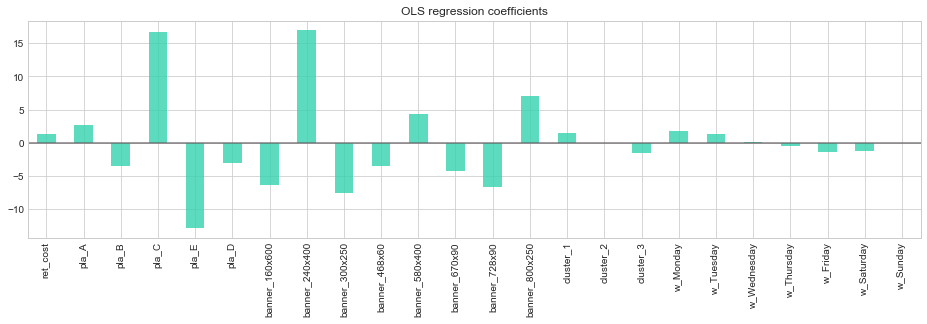

In [30]:
ols_coef0 = []
for col, coef in zip(reg_df.columns[np.r_[6, 14:37]], reg0.coef_):
    ols_coef0.append([col, coef])
ols_coef0 = pd.DataFrame(ols_coef0).set_index(0)

ax = ols_coef0.plot(
    kind="bar",
    color=cpal[2],
    alpha=.8,
    figsize=(16, 4),
    legend=False,
    title="OLS regression coefficients")
plt.axhline(y=0, color="#635f62", alpha=.8)
ax.set_xlabel("");

### Random forest regressor
This method captures better the relationship between costs and revenues but makes mistakes such as confusing the fact that a lot of budget has been allocated to placement E with placement E having a positive impact on revenues (comparatively to other placements). Measuring performance with the mean squared error, the model is inferior to OLS regression.

In [31]:
reg1 = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=0)
reg1 = reg1.fit(X, y)

reg_df["pred_y_rand"] = reg1.predict(reg_df[reg_df.columns[np.r_[6, 14:37]]])

print("mean squared error: ",
      metrics.mean_squared_error(reg_df[reg_df.day.dt.month == 6].ret_revenue,
                                  reg_df[reg_df.day.dt.month == 6].pred_y_rand))

mean squared error:  1434.3081732


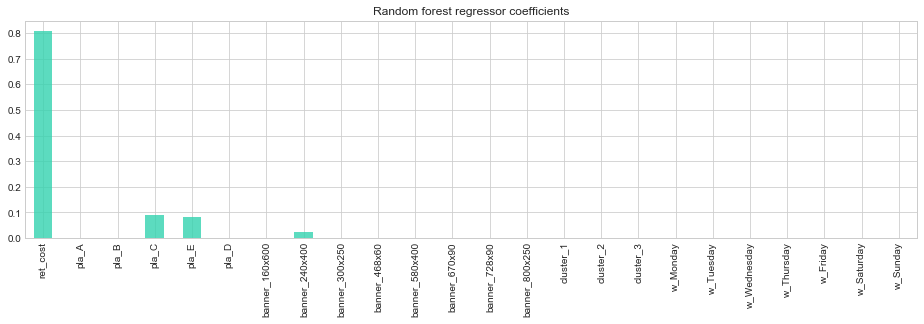

In [32]:
ols_coef1 = []
for col, coef in zip(reg_df.columns[np.r_[6, 14:37]],
                     reg1.feature_importances_):
    ols_coef1.append([col, coef])
ols_coef1 = pd.DataFrame(ols_coef1).set_index(0)

ax = ols_coef1.plot(
    kind="bar",
    color=cpal[2],
    alpha=.8,
    figsize=(16, 4),
    legend=False,
    title="Random forest regressor coefficients")
ax.set_xlabel("");

### Support vector regression
The SVR gives a much smaller mean square error than the random forest but the OLS regression is doing better according to this measure.

In [33]:
reg2 = svm.SVR(kernel="rbf")
reg2 = reg2.fit(X, y)

reg_df["pred_y_svr"] = reg2.predict(reg_df[reg_df.columns[np.r_[6, 14:37]]])

print("mean squared error: ",
      metrics.mean_squared_error(reg_df[reg_df.day.dt.month == 6].ret_revenue,
                                  reg_df[reg_df.day.dt.month == 6].pred_y_svr))

mean squared error:  530.760891025


### Neural network
The neural network selected is a multi-layer perceptron regressor with 5 hidden layers. It has the best predictive power of all models as measured by the mean squared error.

In [34]:
reg3 = MLPRegressor(solver="adam", hidden_layer_sizes=(5,), random_state=0)
reg3 = reg3.fit(X, y)

reg_df["pred_y_neur"] = reg3.predict(reg_df[reg_df.columns[np.r_[6, 14:37]]])

print("mean squared error: ",
      metrics.mean_squared_error(reg_df[reg_df.day.dt.month == 6].ret_revenue,
                                  reg_df[reg_df.day.dt.month == 6].pred_y_neur))

mean squared error:  292.92360765


## Results

While some models perform better than others, the gist is that all them would have still been able to show that decisions made in June weren't the best solely based on the previous month's patterns. In other words, the further drop in June revenues could have been foreseen and is due to a combination of poor banner feature choices (size and placement) and continued space acquisition budget cuts.

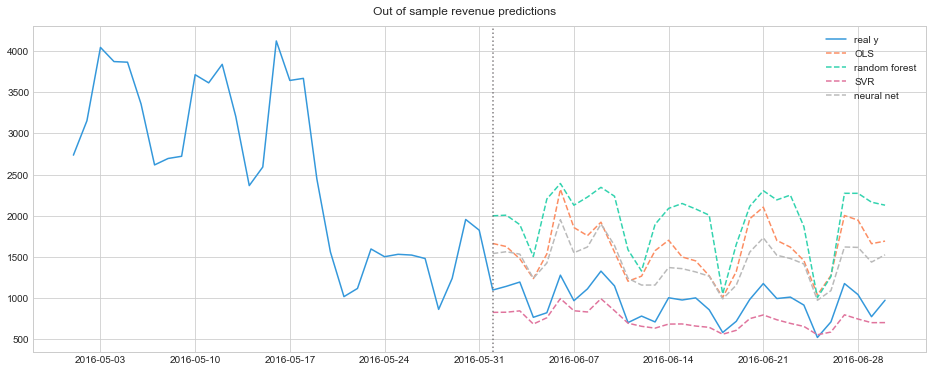

In [35]:
reg_pred = reg_df.groupby("day").sum()[reg_df.groupby("day").sum().index.month
                                       >= 6]

fig, ax = plt.subplots(figsize=(16, 6))

l0 = ax.plot(
    reg_df.groupby("day").sum()[reg_df.groupby("day").sum().index.month
                                >= 5].ret_revenue, color=cpal[0], label="real y")
l1 = plt.plot(reg_pred.pred_y_ols, color=cpal[5], linestyle="--", label="OLS")
l2 = plt.plot(
    reg_pred.pred_y_rand, color=cpal[2], linestyle="--", label="random forest")
l3 = plt.plot(reg_pred.pred_y_svr, color=cpal[1], linestyle="--", label="SVR")
l4 = plt.plot(reg_pred.pred_y_neur, color=cpal[7], linestyle="--", label="neural net")

lns = l0 + l1 + l2 + l3 + l4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=1)
plt.axvline(
    x=pd.Timestamp("2016-06-01"), color="#635f62", linestyle=":", alpha=.8)
fig.suptitle(t="Out of sample revenue predictions", y=.925);

### Ensemble learning

The predictive force of my models could probably be increased through boosting and/or stacking methods. My neural network regressor tends to frequently overestimate the revenues while the SVR tends to underestimate them. Having models with different weaknesses is usually a promising setting for ensemble learning gains. 

However, I am satisfied with the predictive force of my models as they are, given that my goal is simply to show that the drop in revenues was somewhat predictable and due to the retargeter and the advertiser's choices (as opposed to external events).   

When stacking, I like to reread this [guide](https://gormanalysis.com/guide-to-model-stacking-i-e-meta-ensembling/) first.

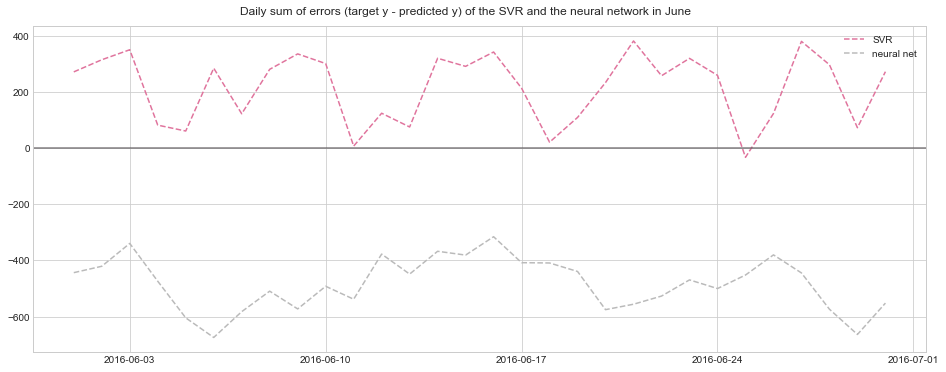

In [36]:
fig, ax = plt.subplots(figsize=(16, 6))

l3 = plt.plot(reg_pred.ret_revenue - reg_pred.pred_y_svr,
    color=cpal[1],
    linestyle="--",
    label="SVR")
l4 = plt.plot(reg_pred.ret_revenue - reg_pred.pred_y_neur,
    color=cpal[7],
    linestyle="--",
    label="neural net")

lns = l3 + l4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
plt.axhline(y=0, color="#635f62", alpha=.8)

fig.suptitle(t="Daily sum of errors (target y - predicted y) of the SVR and the neural network in June", y=.925);